In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from data_util import *

from data_generator import DataGenerator

import model as model_util

from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.layers import InputLayer, BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras import datasets, layers, models

import tensorflow as tf
import tensorflow.keras as keras
import autokeras as ak
import kerastuner


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

from numpy import array
import numpy as np



In [2]:
def reset_seed():
    seed_value= 100
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

reset_seed()

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

path = "./data/"
model_path = path + "stock.h5"

In [3]:
trainX_raw, trainY_raw = load_data("btceur", "train", path)
valX_raw, valY_raw = load_data("btceur", "Val", path)

trainX_balanced, trainY_balanced = get_balanced_set(trainX_raw, trainY_raw)

valX, valY = valX_raw, valY_raw

normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(trainX_raw)


print("{} {}".format(trainX_balanced.shape, valX.shape))

features = trainX_raw.shape[-1:]

(39066, 26) (3683, 26)


In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier

from sklearn import linear_model

def show_feature_importances(tree):
    title = 'Feature Importance:'
    figsize = (15, 5)

    feat_imp = pd.DataFrame({'Importance':tree.feature_importances_})    
    feat_imp['feature'] = [i for i in range(features[-1])]
    feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
    feat_imp = feat_imp

    feat_imp.sort_values(by='Importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
def show_confusion_matrix(tree, trainX, trainY):
    tree.fit(trainX, trainY)
    print(f'Train Accuracy: {tree.score(trainX, trainY)}')
    print(f'Val Accuracy: {tree.score(valX, valY)}')
    y_pred = tree.predict(valX)
    print(confusion_matrix(valY, y_pred))
    print(f1_score(valY, y_pred))

def eval_tree(tree, trainX, trainY, valX, valY):
    print(tree)

    param_grid = [
        {'n_estimators': [10,40, 50, 60, 100],
        'max_depth': [4, 5, 6, 10],
        'max_features': [4,6,8,10]
        }
    ]
    grid_search = GridSearchCV(tree, param_grid, cv = 5, scoring = 'accuracy', verbose = 1)
    grid_search.fit(trainX, trainY)
    
    show_confusion_matrix(tree, trainX, trainY)
    show_feature_importances(tree)
    
    

estimators = 300

BATCH_SIZE = 32

tress = [
        RandomForestClassifier(random_state=5)
        ,DecisionTreeClassifier(min_samples_leaf=600)
        ,ExtraTreesClassifier(n_estimators=estimators)
        ,GradientBoostingClassifier(n_estimators=estimators, learning_rate=1.0,  max_depth=1000, random_state=0)
        ,GaussianNB()
        ,linear_model.Ridge(alpha=.5)
        ,RidgeClassifier(alpha=.5)
        ,AdaBoostClassifier(n_estimators=estimators)
        ]

def fit_model(model, trainX, trainY, valX, valY):
    print("Fiting: {}".format(model))
    early_stopping = tf.keras.callbacks.EarlyStopping(
        #monitor='val_precision', 
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    callbacks_list = [early_stopping]
    
    epochs = 1000
    
    #compile_model(model)
    
    model.fit(
            x=trainX,
            y=trainY,
            validation_data=(valX, valY),
            epochs=epochs,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=callbacks_list
        )

    print(confusion_matrix(valY, model.predict(valX) > 0.5))
    model.evaluate(valX, valY, verbose=1)

    
def fit_model_autokeras(model, trainX, trainY, valX, valY):
    print("Fiting: {}".format(model))
    early_stopping = tf.keras.callbacks.EarlyStopping(
        #monitor='val_precision', 
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

    callbacks_list = [early_stopping]
    
    epochs = 1000
    
    model.fit(
            x=trainX,
            y=trainY,
            validation_data=(valX, valY),
            epochs=epochs,
            batch_size=BATCH_SIZE,
            verbose=0,
            callbacks=callbacks_list
        )

    print(confusion_matrix(valY, model.predict(valX) > 0.5))

In [5]:
from sklearn.model_selection import GridSearchCV

def fit(x, y):
    param_grid = [
        {
        'n_estimators': [10,40, 50, 60, 100],
        'max_depth': [4, 5, 6, 10],
        'max_features': [4,6,8,10]
        }
    ]

    clf2 = RandomForestClassifier(random_state=5)

    grid_search = GridSearchCV(clf2, param_grid, cv = 5, scoring = 'accuracy', verbose = 1)

    grid_search.fit(x, y)

    best_params = grid_search.best_params_

    print(best_params)

    clf_opt = RandomForestClassifier(**best_params)

    clf_opt.fit(x, y)
    
    return clf_opt

clf_opt = fit(trainX_balanced, trainY_balanced)


#clf_opt = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
#                                     multi_class='auto',
#                                     max_iter=910000)


#clf_opt.fit(trainX_balanced, trainY_balanced)
#clf_opt.fit(trainX_raw, trainY_raw)

print(clf_opt.score(trainX_raw, trainY_raw))
print(clf_opt.score(valX, valY))


Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'max_depth': 10, 'max_features': 8, 'n_estimators': 100}
0.9230840773809523
0.8251425468368178


              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3317
           1       0.07      0.06      0.06       366

    accuracy                           0.83      3683
   macro avg       0.48      0.48      0.48      3683
weighted avg       0.81      0.83      0.82      3683

Confusion Matrix Train
[[3018  299]
 [ 345   21]]

Accuracy Test
0.8251425468368178
0.065625


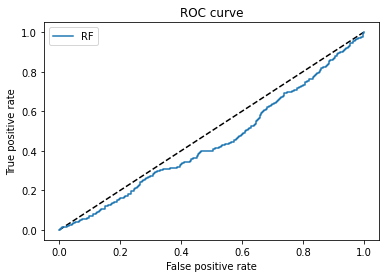

In [9]:
def evaluate(clf_opt, x, y):
    
    preds = clf_opt.predict(x)
    
    report = classification_report(y, preds)
    print(report)

    # Performance Metrics
    y_pred_rf = clf_opt.predict_proba(x)[:, 1]

    fpr_rf, tpr_rf, _ = roc_curve(y, y_pred_rf)

    print("Confusion Matrix Train")
    print(confusion_matrix(y, preds))

    print('')
    print("Accuracy Test")
    print(accuracy_score(y, preds))
    print(precision_score(y, preds))

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

#evaluate(clf_opt, trainX_raw, trainY_raw)
evaluate(clf_opt, valX, valY)

In [ ]:
### GridSearchCV
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from keras.wrappers.scikit_learn import KerasClassifier

def get_model_test(features = features, 
              layers = 1, 
              units = 5, 
              optimizer="Adam",
              init='glorot_uniform'):
    
    reset_seed()
    inputX = Input(shape=features)
    
    x = normalizer(inputX)
    
    for lay in range(int(layers)):
        x = Dense(units, kernel_initializer=init, activation='relu')(x)
    
    x = Dense(10, kernel_initializer=init, activation='relu')(x)
    
    x = Dense(1, kernel_initializer=init, activation='sigmoid')(x)

    model = Model(inputs=[inputX], outputs=x)
    
    model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=METRICS)
    
    return model


model = KerasClassifier(build_fn=get_model_test, verbose=0,
                    validation_data=(valX, valY))
# grid search epochs, batch size and optimizer
optimizers = [
              "Adadelta", 
              "Nadam",
              "Ftrl",
]

init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50]
batches = [64]
features = features
layers = [20, 10]
units = [10, 64]

#get_simple_model(features[0]).summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
        #monitor='val_precision', 
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

param_grid = dict(
                    optimizer=optimizers, 
                    epochs=epochs, 
                    batch_size=batches,
                    layers = layers,
                    units = units,
                    features = features,
                    init=init
                  )

grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1, n_jobs=1)

grid_result = grid.fit(trainX_balanced, trainY_balanced, callbacks=[early_stopping])


In [ ]:
print(grid_result.best_params_)
best_final_param = grid_result.best_params_
del best_final_param['batch_size']
del best_final_param['epochs']


In [ ]:
best_model = get_model_test(**best_final_param)
print(best_final_param)
fit_model(best_model, trainX_balanced, trainY_balanced, valX, valY)

In [ ]:
model = get_model_test(**{'features': 9, 
                               'init': 'glorot_uniform', 
                               'layers': 5, 
                               'optimizer': 'Nadam', 
                               'units': 10})
fit_model(model, trainX_balanced, trainY_balanced, valX, valY)

In [ ]:
def show_metric(history, metric): 
    plt.plot(history.history[metric])
    plt.plot(history.history["val_{}".format(metric)])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#show_metric(history, "loss")
#show_metric(history, "precision")

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(history)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('True Positives: ', cm[1][1])

    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:


baseline_results = model.evaluate(valX, valY, verbose=1)


for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)



In [ ]:
plot_cm(valY, model.predict(valX))
print(test_predictions_baseline.shape)

In [ ]:
#Model 

from tensorflow.keras.layers import InputLayer, BatchNormalization, GlobalMaxPool1D, Bidirectional, Dense, Flatten, Conv2D, LeakyReLU, Dropout, LSTM, GRU, Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras import datasets, layers, models

import tensorflow as tf
#import tensorflow_addons as tfa
 
#Model 

dim = 100

def add_deep_layers(x, dropout, units):
    #x = Dropout(0.2)(x)
    x = Dense(units, kernel_initializer=init, activation='relu')(x)
    x = Dropout(dropout)(x)
    #x = Dense(units, activation='relu')(x)
    return x

def get_model(features, layers, units):
    reset_seed()
    inputX = Input(shape=features)
    
    x = normalizer(inputX)
    
    for lay in range(int(layers)):
        x = add_deep_layers(x, 0.2, units)
    
    x = Dense(10, activation='relu')(x)
    
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inputX], outputs=x)
    
    return model


def generate_model_rnn(seqs, 
                       features,
                       units, 
                       dropout, 
                       lays, 
                       lays_seq, 
                       init):
    inputX = Input(shape=(seqs, features))
    
    x = inputX
    x = normalizer(inputX)
    
    for lay in range(int(lays_seq)):
        x = LSTM(units=units, kernel_initializer=init, return_sequences=True)(x)
    
    #x = Bidirectional(LSTM(dim, return_sequences=False))(x)
    x = LSTM(dim, kernel_initializer=init, return_sequences=False)(x)
    
    for lay in range(int(lays)):
        x = add_deep_layers(x, dropout, units)
        
    x = Dense(20, kernel_initializer=init, activation='relu')(x)
    
    x = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[inputX], outputs=x)


def compile_model(model):
    model.compile(
        #optimizer=ranger,
        optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.00001, rho=0.95, epsilon=1e-07),
        #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=METRICS
    )

path = "./data/"


In [ ]:


#model = load_model(filepath = "drive/My Drive/model/stock.h5")

#!rm "drive/My Drive/model/encoder.h5"

def get_simple():
    model = Sequential()
    reset_seed()
    model.add(InputLayer(input_shape=features))
    model.add(normalizer)
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model



def autokeras_class(max_trials = 30):
    clf = ak.StructuredDataClassifier(overwrite=True, 
                                  max_trials=max_trials,
                                  metrics=METRICS,
                                  objective=kerastuner.Objective("val_prc", direction="max"),
                                  project_name = "AutoKeras",
                                  #tuner='random',
                                 )
    return clf

def autokeras_time_class(max_trials = 30):
    predict_from = 1
    predict_until = 10
    lookback = 0

    return ak.TimeseriesForecaster(
                              max_trials=max_trials,
                              metrics=METRICS,
                                  objective=kerastuner.Objective("val_prc", direction="max"),
                              project_name = "AutoKeras Time",
                              #tuner='random',
                             )


In [ ]:
model = clf.export_model()
model.summary()

In [ ]:
max = 40
a = [[i, i] for i in range(max)]


def gen_y(i):
    if (i > 35):
        return 1
    else:
        return 0

b = [gen_y(i) for i in range(max)]

In [ ]:
xx, yy = create_dataset(a, b, time_steps=3, null_value = 0)

print(xx.shape)
print(yy.shape)

counter = Counter(yy)
print("{} - {}".format(counter, (counter[0] - counter[1])))

x_balanced, y_balanced = get_balanced_set_seq(xx, yy)

print(x_balanced.shape)
print(y_balanced.shape)

counter = Counter(y_balanced)
print("{} - {}".format(counter, (counter[0] - counter[1])))

In [ ]:
#print(x_balanced) 

index = -4
#print(x_balanced[index][-1][-1]) 
#print(y_balanced[index])

for i in range(len(x_balanced)):
    xx = x_balanced[i][-1][-1]
    if (xx < 35):
        print("{}) {} - {}".format(i, xx, y_balanced[i]))


In [ ]:
print(trainX.shape)
print(trainY.shape)

x_, y_ = create_dataset(trainX, trainY, time_steps=20, null_value = 0)

print(x_.shape)
print(y_.shape)

counter = Counter(y_)
print("{} - {}".format(counter, (counter[0] - counter[1])))

x_balanced, y_balanced = get_balanced_set_seq(x_, y_)

print(x_balanced.shape)
print(y_balanced.shape)

counter = Counter(y_balanced)
print("{} - {}".format(counter, (counter[0] - counter[1])))

In [ ]:
### RNN
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from keras.wrappers.scikit_learn import KerasClassifier

def get_data(trainX_raw, trainY_raw, valX_raw, valY_raw, time_steps=10)
    x_balanced, y_balanced = get_balanced_set_seq(trainX_raw, trainY_raw, time_steps=time_steps)
    val_x_balanced, val_y_balanced = get_balanced_set_seq(valX_raw, valY_raw, time_steps=time_steps)


    counter = Counter(y_balanced)
    print("{} - {}".format(counter, (counter[0] - counter[1])))

    return x_balanced, y_balanced, val_x_balanced, val_y_balanced

seqs = 10

trainX_balanced, trainY_balanced, valX, valY = get_data(trainX_raw,
                                                        trainY_raw, 
                                                        valX_raw, 
                                                        valY_raw, 
                                                        seqs)

In [ ]:
model = KerasClassifier(build_fn=generate_model_rnn, verbose=0,
                    validation_data=(valX, valY))
# grid search epochs, batch size and optimizer
optimizers = [
              "Adadelta", 
              "Nadam",
              "Adam",
]

init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50]
batches = [64]
features = [features]
layers = [20, 10]
lays_seq = [2, 5]
units = [10, 64]
seqs = [seqs]


#get_simple_model(features[0]).summary()

early_stopping = tf.keras.callbacks.EarlyStopping(
        #monitor='val_precision', 
        monitor='val_prc', 
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True)

param_grid = dict(
    optimizer=optimizers, 
    epochs=epochs, 
    batch_size = batches,
    seqs = seqs, 
    features = features, 
    units = units, 
    dropout = [0.2],
    lays = lays,
    lays_seq = lays_seq 
)

grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1, n_jobs=1)

grid_result = grid.fit(trainX_balanced, trainY_balanced, callbacks=[early_stopping])
